In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
# GPU 사용 설정

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


In [4]:

from IPython.display import HTML, display

# 훈련 단계: 진행 모니터
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

In [5]:
# 디렉터리
train_directory = os.path.join("/content/drive/MyDrive/datasets/train")
test_directory = os.path.join("/content/drive/MyDrive/datasets/test")


In [6]:
# 하이퍼파라미터
lr = 0.001
batch_size = 4
num_epochs = 50
momentum = 0.9
gamma = 0.1

In [7]:
# Training을 위한 데이터 확장과 데이터셋 정규화

train_transforms = transforms.Compose([
        transforms.Resize([224,224]),  # 리사이즈
        transforms.RandomHorizontalFlip(),  # 좌우반전
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ])

# Test를 위해서는 데이터셋 정규화만

test_transforms = transforms.Compose([
        transforms.Resize([224,224]),             # 리사이즈
        transforms.CenterCrop(224),         # 가운데 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ])

In [8]:
# ImageFolder를 사용하여 폴더 안에 있는 이미지들을 데이터셋으로 사용

train_dataset = datasets.ImageFolder( train_directory, train_transforms)
test_dataset = datasets.ImageFolder( test_directory, test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

class_names = train_dataset.classes
print(class_names)


['0', '1', '2', '3', '4', '5']


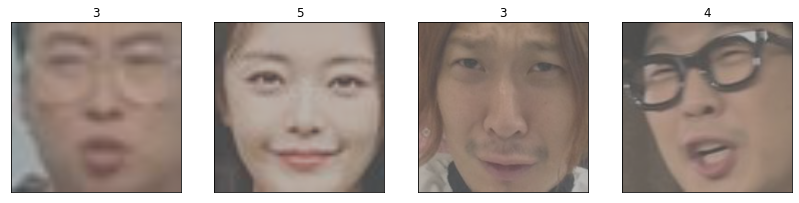

In [9]:
def convert_to_imshow_format(image):
    # 3 x Height x Width --> Height x Width x 3
    image = image.numpy().transpose(1,2,0)

    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.229, 0.224, 0.225])
    
    # [-1,1] --> [0,1] 범위
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images[:6], labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(14,4))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [10]:
# Pretrained 모델

# model = models.vgg11(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.resnet50(pretrained=True)
model = models.densenet121(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)
# model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [11]:
# GPU로 모델 전송
model = model.to(device)

# 손실함수
loss_func = nn.CrossEntropyLoss()

# 최적화 SGD 사용
optimizer_ft = optim.SGD( model.parameters(), lr=lr, momentum=momentum )

# LR Scheduler 사용
# 매 7 epoch 마다 기존 학습률에 0.1을 곱해주는 방식으로 학습률이 점점 작아지게
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=gamma)

In [12]:
def train(epoch, num_epochs, model, optimizer, scheduler):

    # 훈련
    model.train()
    
    # 진행 모니터 생성
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    correct_train = 0

    for batch, target in train_loader:
        # GPU로 훈련 데이터 이동
        batch, target = batch.to(device), target.to(device)

        # 순전파
        output = model( batch )

        # 손실값 계산
        loss = loss_func( output, target )
        
        # 그래디언트 초기화
        optimizer.zero_grad()
 
        # Backpropagation
        loss.backward()
 
        # 모델 가중치 업데이트
        optimizer.step()

        # 진행바 업데이트
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

        # 맞은 개수 누적
        preds = torch.argmax(output, 1)
        correct_train += (preds == target).sum().item()


    # 러닝 레이트 스케쥴러 업데이트
    if scheduler:
        scheduler.step()

    # 훈련 정확도 계산    
    acc = 100 * correct_train / len(train_dataset) 
    print( 'Train acc: {}/{} ({:.2f}%)'.format( correct_train, len(train_dataset), acc ) )

    return acc
        
        

In [13]:
def test(model):
    # 테스트 (validation)
    model.eval()

    correct = 0
    
    with torch.no_grad():
        for batch, target in test_loader:
            # GPU로 테스트 데이터 이동
            batch, target = batch.to(device), target.to(device)

            # 순전파
            output = model( batch )

            # 예측값 계산
            output = torch.argmax(output, 1)

            # 맞은 개수 누적
            correct += (output == target).sum().item()

    # 테스트 정확동 계산 
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [14]:
since = time.time()

# 현재 모델의 가중치 저장
best_model_weights = copy.deepcopy( model.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # 훈련
    train(epoch+1, num_epochs, model, optimizer_ft, lr_scheduler_ft )
    # 테스트
    acc = test(model)

    # 지금까지보다 더 좋은 성능이 나온 가중치라면 저장
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model.state_dict() )

# 최고 성능 가중치 로드
model.load_state_dict( best_model_weights )

# 요약
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))



Epoch: 1/50 Loss: 1.7407 1200 / 1200,1200


Train acc: 601/1200 (50.08%)
Test Acc: 582/780 (74.62%)


Epoch: 2/50 Loss: 0.8797 1200 / 1200,1200


Train acc: 857/1200 (71.42%)
Test Acc: 656/780 (84.10%)


Epoch: 3/50 Loss: 0.5853 1200 / 1200,1200


Train acc: 983/1200 (81.92%)
Test Acc: 643/780 (82.44%)


Epoch: 4/50 Loss: 0.4355 1200 / 1200,1200


Train acc: 1031/1200 (85.92%)
Test Acc: 712/780 (91.28%)


Epoch: 5/50 Loss: 0.3931 1200 / 1200,1200


Train acc: 1045/1200 (87.08%)
Test Acc: 718/780 (92.05%)


Epoch: 6/50 Loss: 0.3084 1200 / 1200,1200


Train acc: 1087/1200 (90.58%)
Test Acc: 703/780 (90.13%)


Epoch: 7/50 Loss: 0.2784 1200 / 1200,1200


Train acc: 1096/1200 (91.33%)
Test Acc: 702/780 (90.00%)


Epoch: 8/50 Loss: 0.1537 1200 / 1200,1200


Train acc: 1144/1200 (95.33%)
Test Acc: 723/780 (92.69%)


Epoch: 9/50 Loss: 0.1072 1200 / 1200,1200


Train acc: 1168/1200 (97.33%)
Test Acc: 739/780 (94.74%)


Epoch: 10/50 Loss: 0.1246 1200 / 1200,1200


Train acc: 1153/1200 (96.08%)
Test Acc: 736/780 (94.36%)


Epoch: 11/50 Loss: 0.0836 1200 / 1200,1200


Train acc: 1178/1200 (98.17%)
Test Acc: 736/780 (94.36%)


Epoch: 12/50 Loss: 0.1568 1200 / 1200,1200


Train acc: 1149/1200 (95.75%)
Test Acc: 736/780 (94.36%)


Epoch: 13/50 Loss: 0.1052 1200 / 1200,1200


Train acc: 1170/1200 (97.50%)
Test Acc: 736/780 (94.36%)


Epoch: 14/50 Loss: 0.0683 1200 / 1200,1200


Train acc: 1183/1200 (98.58%)
Test Acc: 736/780 (94.36%)


Epoch: 15/50 Loss: 0.1149 1200 / 1200,1200


Train acc: 1162/1200 (96.83%)
Test Acc: 733/780 (93.97%)


Epoch: 16/50 Loss: 0.1045 1200 / 1200,1200


Train acc: 1166/1200 (97.17%)
Test Acc: 739/780 (94.74%)


Epoch: 17/50 Loss: 0.0995 1200 / 1200,1200


Train acc: 1166/1200 (97.17%)
Test Acc: 737/780 (94.49%)


Epoch: 18/50 Loss: 0.0937 1200 / 1200,1200


Train acc: 1170/1200 (97.50%)
Test Acc: 737/780 (94.49%)


Epoch: 19/50 Loss: 0.1025 1200 / 1200,1200


Train acc: 1173/1200 (97.75%)
Test Acc: 737/780 (94.49%)


Epoch: 20/50 Loss: 0.0726 1200 / 1200,1200


Train acc: 1175/1200 (97.92%)
Test Acc: 737/780 (94.49%)


Epoch: 21/50 Loss: 0.0917 1200 / 1200,1200


Train acc: 1175/1200 (97.92%)
Test Acc: 737/780 (94.49%)


Epoch: 22/50 Loss: 0.0696 1200 / 1200,1200


Train acc: 1177/1200 (98.08%)
Test Acc: 739/780 (94.74%)


Epoch: 23/50 Loss: 0.0795 1200 / 1200,1200


Train acc: 1169/1200 (97.42%)
Test Acc: 734/780 (94.10%)


Epoch: 24/50 Loss: 0.0690 1200 / 1200,1200


Train acc: 1178/1200 (98.17%)
Test Acc: 737/780 (94.49%)


Epoch: 25/50 Loss: 0.0880 1200 / 1200,1200


Train acc: 1170/1200 (97.50%)
Test Acc: 740/780 (94.87%)


Epoch: 26/50 Loss: 0.0789 1200 / 1200,1200


Train acc: 1173/1200 (97.75%)
Test Acc: 733/780 (93.97%)


Epoch: 27/50 Loss: 0.0872 1200 / 1200,1200


Train acc: 1167/1200 (97.25%)
Test Acc: 740/780 (94.87%)


Epoch: 28/50 Loss: 0.0925 1200 / 1200,1200


Train acc: 1169/1200 (97.42%)
Test Acc: 738/780 (94.62%)


Epoch: 29/50 Loss: 0.0654 1200 / 1200,1200


Train acc: 1175/1200 (97.92%)
Test Acc: 737/780 (94.49%)


Epoch: 30/50 Loss: 0.0946 1200 / 1200,1200


Train acc: 1167/1200 (97.25%)
Test Acc: 737/780 (94.49%)


Epoch: 31/50 Loss: 0.0995 1200 / 1200,1200


Train acc: 1169/1200 (97.42%)
Test Acc: 734/780 (94.10%)


Epoch: 32/50 Loss: 0.0692 1200 / 1200,1200


Train acc: 1174/1200 (97.83%)
Test Acc: 737/780 (94.49%)


Epoch: 33/50 Loss: 0.0725 1200 / 1200,1200


Train acc: 1182/1200 (98.50%)
Test Acc: 737/780 (94.49%)


Epoch: 34/50 Loss: 0.0699 1200 / 1200,1200


Train acc: 1181/1200 (98.42%)
Test Acc: 736/780 (94.36%)


Epoch: 35/50 Loss: 0.0892 1200 / 1200,1200


Train acc: 1170/1200 (97.50%)
Test Acc: 737/780 (94.49%)


Epoch: 36/50 Loss: 0.0682 1200 / 1200,1200


Train acc: 1184/1200 (98.67%)
Test Acc: 737/780 (94.49%)


Epoch: 37/50 Loss: 0.0860 1200 / 1200,1200


Train acc: 1174/1200 (97.83%)
Test Acc: 737/780 (94.49%)


Epoch: 38/50 Loss: 0.0880 1200 / 1200,1200


Train acc: 1174/1200 (97.83%)
Test Acc: 737/780 (94.49%)


Epoch: 39/50 Loss: 0.0823 1200 / 1200,1200


Train acc: 1174/1200 (97.83%)
Test Acc: 733/780 (93.97%)


Epoch: 40/50 Loss: 0.0588 1200 / 1200,1200


Train acc: 1186/1200 (98.83%)
Test Acc: 739/780 (94.74%)


Epoch: 41/50 Loss: 0.0837 1200 / 1200,1200


Train acc: 1174/1200 (97.83%)
Test Acc: 738/780 (94.62%)


Epoch: 42/50 Loss: 0.0922 1200 / 1200,1200


Train acc: 1169/1200 (97.42%)
Test Acc: 739/780 (94.74%)


Epoch: 43/50 Loss: 0.0688 1200 / 1200,1200


Train acc: 1177/1200 (98.08%)
Test Acc: 738/780 (94.62%)


Epoch: 44/50 Loss: 0.1149 1200 / 1200,1200


Train acc: 1161/1200 (96.75%)
Test Acc: 739/780 (94.74%)


Epoch: 45/50 Loss: 0.0843 1200 / 1200,1200


Train acc: 1177/1200 (98.08%)
Test Acc: 737/780 (94.49%)


Epoch: 46/50 Loss: 0.0810 1200 / 1200,1200


Train acc: 1173/1200 (97.75%)
Test Acc: 738/780 (94.62%)


Epoch: 47/50 Loss: 0.1105 1200 / 1200,1200


Train acc: 1159/1200 (96.58%)
Test Acc: 737/780 (94.49%)


Epoch: 48/50 Loss: 0.0718 1200 / 1200,1200


Train acc: 1183/1200 (98.58%)
Test Acc: 735/780 (94.23%)


Epoch: 49/50 Loss: 0.0729 1200 / 1200,1200


Train acc: 1173/1200 (97.75%)
Test Acc: 738/780 (94.62%)


Epoch: 50/50 Loss: 0.0850 1200 / 1200,1200


Train acc: 1175/1200 (97.92%)
Test Acc: 737/780 (94.49%)
Training completed in 72m 37s
Best test accuracy: 94.871795


In [15]:
torch.save(model,'DenseNet121_model.pt' )